In [35]:
import numpy as np
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')
import matplotlib.pyplot as plt
import sys
import tables as pt
import importlib
import Compute_evolution_of_MSD_gpt
importlib.reload(Compute_evolution_of_MSD_gpt)
from Compute_evolution_of_MSD_gpt import *

/tmp/ipykernel_88079/3958292661.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


In [2]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
kdiff = 1.
Energy = -15
Nprocess = 10
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]
# Simulation parameters
step_tot = 2*10**5
compute_steps = 10**4

In [3]:
parallel_MSD_evolution(args,step_tot,compute_steps,"MSD_test.hdf")

In [13]:
def compute_average_msd_with_binning(msd_data, num_bins=10):
    """
    Compute the average MSD over all simulations with binning.
    
    Parameters:
    - msd_data: A list of numpy arrays containing MSD data.
    - num_bins: The number of bins to use for the time axis.
    
    Returns:
    - Binned time steps and corresponding average MSD values.
    """
    # Concatenate all time points to find the range
    all_time_points = np.concatenate([data[:, 0] for data in msd_data])
    
    # Determine bins for the entire range of time points
    bins = np.linspace(all_time_points.min(), all_time_points.max(), num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initialize array to hold average MSD values for each bin
    average_msd = np.zeros(num_bins)
    
    for i in range(num_bins):
        # Find indices of time points that fall into the current bin
        msd_values = []
        
        for data in msd_data:
            indices = np.digitize(data[:, 0], bins) - 1  # -1 to correct indices since np.digitize bins start from 1
            within_bin = data[(indices == i), 1]
            
            if within_bin.size > 0:
                msd_values.extend(within_bin)
        
        # Compute average MSD for the current bin
        if msd_values:
            average_msd[i] = np.mean(msd_values)
    
    return bin_centers, average_msd

In [70]:
# Assuming 'my_simulations.h5' is the filename of your HDF5 file
hdf5_filename = 'MSD_test.hdf'

msd_data = []
with pt.open_file(hdf5_filename, mode='r') as hdf:
    # Assuming '/MSD_tot' is the group containing all simulations' MSD data
    for array in hdf.root.MSD_tot:
        msd_data.append(array.read())
    msd_data = np.array(msd_data)

msd_time_point = []
with pt.open_file(hdf5_filename, mode='r') as hdf:
    for array in hdf.root.Evolution_of_MSD:
        print(array._v_name)
        msd_time_point.append(array.read())
msd_time_point = np.array(msd_time_point)

MSD_0x23a8b
MSD_0x3b078
MSD_0x46035
MSD_0x72078
MSD_0x79cce
MSD_0x7cb3d
MSD_0xa72cd
MSD_0xc41d1
MSD_0xdf856
MSD_0xe4212


In [67]:
msd_time_point.shape

(10, 20, 10000, 2)

In [73]:
Nbin = 100
av_msd = np.zeros((msd_time_point.shape[1],2,Nbin),dtype=float)
for i in range(msd_time_point.shape[1]):
    av_msd[i] = compute_average_msd_with_binning(msd_time_point[:,i,:,:],num_bins=Nbin)

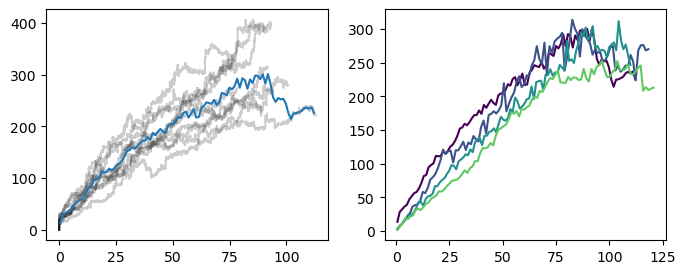

In [78]:
fig,ax = plt.subplots(figsize=(8,3),ncols = 2)
step = 0
for i,time_point in enumerate(msd_time_point[:,step]):
    ax[0].plot(time_point[:,0],time_point[:,1],color='black',alpha= 0.2)
ax[0].plot(av_msd[step,0],av_msd[step,1])
for i,msd in enumerate(av_msd[[0,5,10,19]]):
    ax[1].plot(msd[0],msd[1],color = cmap(i/4))


In [15]:
binned_time_steps, average_msd = compute_average_msd_with_binning(msd_data,num_bins=10**3)

(0.0, 1000.0)

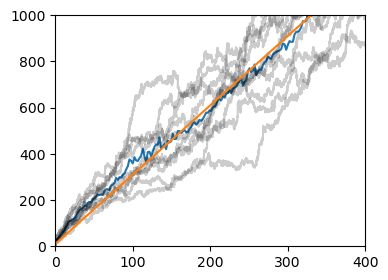

In [89]:
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(binned_time_steps,average_msd)
for data in msd_data:
    plt.plot(data[:,0],data[:,1],alpha=0.2,color='black')
plt.plot(data[:,1],3*data[:,1]+10)
plt.xlim(0,400)
plt.ylim(0,1000)